This notebook is the pre construct of the ETL of the main database

Importing the libraries needed and the dataframes

In [1]:
import numpy as np
import pandas as pd
import re
from nltk.tokenize import word_tokenize
import sqlite3


def load_data():
    '''loads the message and categories dataframes'''
    
    messages = pd.read_csv('data/disaster_messages.csv')
    categories_df = pd.read_csv('data/disaster_categories.csv')
    
    return messages, categories_df

messages, categories_df = load_data()

In [2]:
def only_numbers(cell):
    '''takes an array, cell, and cleans all the non alphanumeric character,
    transforms them into a list of integers and returns that list
    '''
    
    cleaned_cell = re.sub(r'[a-zA-Z_-]+', '', cell)
    cleaned_cell = list(map(int,cleaned_cell.split(';')))
    return cleaned_cell

def cleaning_categories(df,column):
    '''takes in a dataframe where a column is composed by words followed by numbers,
    and transforms it into a dataframe where the words(first row only) are the columns and the numbers are in
    the rows of the respective columns
    Also removes the words who have a zero count, that is the number which followed it was always zero.
    
    column - column to clean (string)
    df - dataframe to clean
    '''
    
    #reading the first row of the dataframe and transforming into an array of words
    column_features = re.sub(r"[-01;]", " ",df[column][0])
    column_features = word_tokenize(column_features )
    
    #creating a temporary dataframe to remove the words and keep the numbers and transform it into a list of lists
    temp_df = df[column]
    fill_df = []    
    for i in range (0,len(temp_df)):    
        fill_df.append(only_numbers(temp_df[i]))
      
    #creating the new dataframe with the expected result
    new_df = pd.DataFrame(np.array(fill_df), columns=[column_features])
    
    #removing the features with only zeros
    new_df = new_df.loc[:,new_df.sum(axis=0)>0]
    
    #removing the rows with all zero values
    new_df = new_df[new_df.sum(axis=1) > 0]
    
    #removing the rows where the features are different than 0 or 1
    new_df = new_df[(new_df.iloc[:,0] == 0) | (new_df.iloc[:,0] == 1)]
    
    return new_df

cleaned_categories = cleaning_categories(categories_df,'categories')

In [3]:
def preparation(messages,cleaned_categories):
    '''takes care of the merging process and final clean up of the dataframes
    '''
    #merging the two dataframes
    df = messages.merge(cleaned_categories,left_index=True, right_index=True)
    
    #fixing column names
    df.rename(columns=lambda col: ''.join(col), inplace=True)
    
    #dropping the columns that will not be used
    df = df.drop(columns=['id','original'])
    
    #creating dummies from the genre column
    df = pd.get_dummies(df,columns=['genre'],drop_first=True)
    
    # dropping duplicate rows 
    df.drop_duplicates(keep=False,inplace=True)
    
    #dropping the related feature - see Data_Exploration_Analysis for further details on why
    df = df.drop(columns=['related'])
    
    return df

df = preparation(messages,cleaned_categories)

In [4]:
def export_data(df):
    '''exports the cleaned dataframe to a SQL database'''
    
    database_name = 'Messages'
    connection = database_name+'.db'
    #opening connection and cursor
    conn = sqlite3.connect(connection)
    c = conn.cursor()
    conn.commit()
    
    #transforming the dataframe to a sql database
    df.to_sql(database_name, conn, if_exists="replace")
    
    #closing connections
    c.close()
    conn.close()

export_data(df)

Final look at the categories frequency and labels count.

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

rowSums = df.iloc[:,1:-2].sum(axis=1)
multiLabel_counts = rowSums.value_counts()
multiLabel_counts = multiLabel_counts.iloc[1:]
sns.set(font_scale = 2)
plt.figure(figsize=(22,10))
ax = sns.barplot(multiLabel_counts.index, multiLabel_counts.values)
plt.title("Comments having multiple labels ")
plt.ylabel('Number of comments', fontsize=18)
plt.xlabel('Number of labels', fontsize=18)#adding the text labels
rects = ax.patches
labels = multiLabel_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

<Figure size 2200x1000 with 1 Axes>

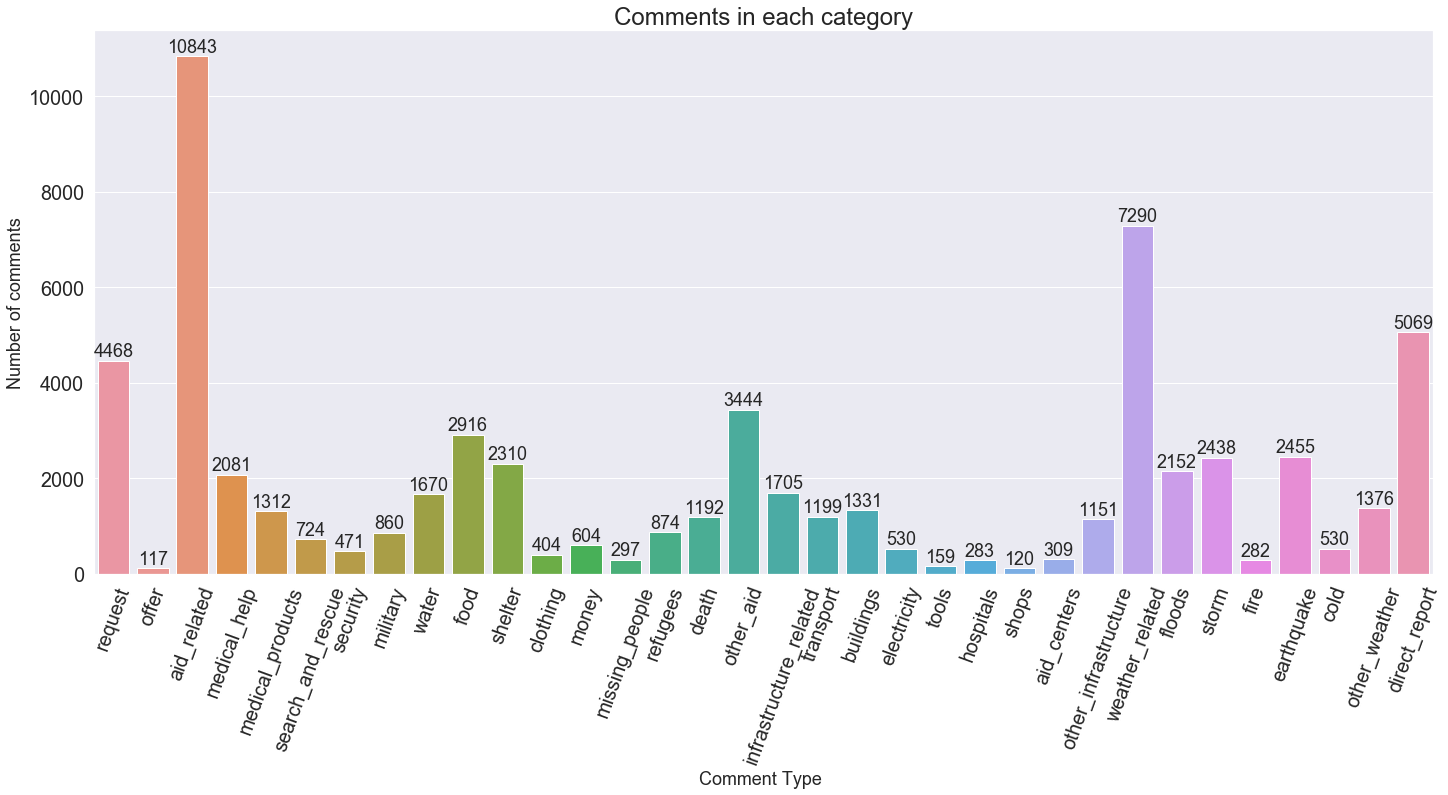

In [6]:
'''the code used for these plots, besides the tweaking to this dataframe, was directly taken from the website:

https://towardsdatascience.com/journey-to-the-center-of-multi-label-classification-384c40229bff

'''

categories = list(df.columns[1:-2].values)
sns.set(font_scale = 1.8)
plt.figure(figsize=(24,10))
ax= sns.barplot(categories, df.iloc[:,1:-2].sum().values)
plt.title("Comments in each category", fontsize=24)
plt.ylabel('Number of comments', fontsize=18)
plt.xlabel('Comment Type ', fontsize=18)#adding the text labels
plt.xticks(rotation=70)
rects = ax.patches
labels = df.iloc[:,1:-2].sum().values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=18)


plt.show()